In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
from sklearn.linear_model import LogisticRegression
from scipy.stats import pointbiserialr, pearsonr, zscore, spearmanr
from natsort import natsort_keygen
from itertools import combinations

## Plotting parameters

In [3]:
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

FIGWIDTH = 7.00697
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
N_TRIALS = 20

# green for gpt-4v, gray for fuyu, purple for adapter, teal for otter, red for humans
model_colors = [
    "#50b990",
    "#8c92ac",
    "#624fe8",
    "#008080",
    "#9b443e",
]

cmap = [
    "#9b443e",
    "#53665c",
    "#ccb3a0",
    "#f4b368",
    "#a08158",
    "#c87858",
    "#94b1d2",
    "#c5d9d8",
    "#e6b951",
    "#666666",
]
sns.set_palette(cmap)


plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


latex_context = {
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
}


# retina figures
mpl.rcParams["figure.dpi"] = 301
mpl.rcParams["savefig.dpi"] = 311

## Load data

In [5]:
# Load data from our own collected .csv file
data = pd.read_csv("data/EXP1_RESULTS.csv").loc[:, :"OTTER"]

# Define subjects
subjects = ["Human", "GPT4V1Q", "FUYU", "ADAPTER", "OTTER"]

# Print first five rows
data.head()

,ExpId,Type,Variable,Lower,Upper,Human,TerrainNo,JointInference,RateInference,Heuristic,Z_JointInference,Z_RateInference,Id,GPT4V1Q,FUYU,ADAPTER,OTTER
0,0,Cost,Outside,-0.520237,0.035730,-0.228961,1.0,6.084458,6.609310,-0.384085,0.638085,0.791911,a,5.0,0,NaN,7.0
1,0,Reward,TopTreat,-0.937563,-0.485594,-0.702174,1.0,5.303722,0.627995,-0.734847,-0.873092,-1.125956,a,0.0,3,NaN,NaN
2,1,Cost,Outside,-0.584346,-0.081584,-0.329477,1.0,3.761888,5.002669,-1.032952,-0.654537,-0.312576,a,7.0,0,NaN,7.0
3,1,Reward,TopTreat,1.175349,1.466409,1.312890,1.0,19.751687,15.241414,1.306395,1.478922,0.759633,a,7.0,3,NaN,7.0
4,2,Cost,Outside,-0.395186,0.067293,-0.170184,1.0,5.383781,4.983377,-0.384085,0.248124,-0.325838,a,5.0,0,3.0,7.0


In [ ]:
# Load data from our own collected .csv file
descriptives = pd.read_csv("data/NUC_DESCRIPTIVES.csv")
descriptives.head()

# Get percentage of correct background color over all three experiments
color_correct = np.zeros(len(subjects[1:]))
for ind, subject in enumerate(subjects[1:]):
    color_correct[ind] = sum(descriptives.loc[descriptives["Question"] == 1, subject].isin(["purple", "pink"])) / len(descriptives.loc[descriptives["Question"] == 1])

In [6]:
# Make new Z-transform columns
for subject in subjects[1:]:
    data[f"{subject}-Z"] = np.zeros(data.shape[0])
    data[f"{subject}-Z"] = np.nan

    # Add z-scored columns for each experiment
    for exp in ["a", "b", "c"]:

        # Z-Score for both judgement types separately
        data.loc[(data["Id"] == exp) & (data["Type"] == "Cost"), f"{subject}-Z"] = zscore(data.loc[(data["Id"] == exp) & (data["Type"] == "Cost"), f"{subject}"], nan_policy="omit")
        data.loc[(data["Id"] == exp) & (data["Type"] == "Reward"), f"{subject}-Z"] = zscore(data.loc[(data["Id"] == exp) & (data["Type"] == "Reward"), f"{subject}"], nan_policy="omit")

# Print first five rows
data.head()

,ExpId,Type,Variable,Lower,Upper,Human,TerrainNo,JointInference,RateInference,Heuristic,...,Z_RateInference,Id,GPT4V1Q,FUYU,ADAPTER,OTTER,GPT4V1Q-Z,FUYU-Z,ADAPTER-Z,OTTER-Z
0,0,Cost,Outside,-0.520237,0.035730,-0.228961,1.0,6.084458,6.609310,-0.384085,...,0.791911,a,5.0,0,NaN,7.0,-0.469029,NaN,NaN,NaN
1,0,Reward,TopTreat,-0.937563,-0.485594,-0.702174,1.0,5.303722,0.627995,-0.734847,...,-1.125956,a,0.0,3,NaN,NaN,-0.450420,-0.204124,NaN,NaN
2,1,Cost,Outside,-0.584346,-0.081584,-0.329477,1.0,3.761888,5.002669,-1.032952,...,-0.312576,a,7.0,0,NaN,7.0,0.617143,NaN,NaN,NaN
3,1,Reward,TopTreat,1.175349,1.466409,1.312890,1.0,19.751687,15.241414,1.306395,...,0.759633,a,7.0,3,NaN,7.0,1.682451,-0.204124,NaN,-0.774597
4,2,Cost,Outside,-0.395186,0.067293,-0.170184,1.0,5.383781,4.983377,-0.384085,...,-0.325838,a,5.0,0,3.0,7.0,-0.469029,NaN,-0.753778,NaN


## Analyze correlation with human data

In [7]:
# Same but only for cost trials
cost = data[data["Type"] == "Cost"]
reward = data[data["Type"] == "Reward"]

# Pre-allocate result arrays
cocorr_all = np.zeros(len(subjects[1:]))
recorr_all = np.zeros(len(subjects[1:]))
heucocorr_all = np.zeros(len(subjects[1:]))
heurecorr_all = np.zeros(len(subjects[1:]))
joicocorr_all = np.zeros(len(subjects[1:]))
joirecorr_all = np.zeros(len(subjects[1:]))
ratcocorr_all = np.zeros(len(subjects[1:]))
ratrecorr_all = np.zeros(len(subjects[1:]))

for ind, subject in enumerate(subjects[1:]):  

    # Get correlation over all three experiments
    cocorr_all[ind] = cost[subject].corr(cost["Human"], method='pearson')
    recorr_all[ind] = reward[subject].corr(reward["Human"], method='pearson')
    heucocorr_all[ind] = cost[subject].corr(cost["Heuristic"], method='pearson')
    heurecorr_all[ind] = reward[subject].corr(reward["Heuristic"], method='pearson')
    joicocorr_all[ind] = cost[subject].corr(cost["JointInference"], method='pearson')
    joirecorr_all[ind] = reward[subject].corr(reward["JointInference"], method='pearson')
    ratcocorr_all[ind] = cost[subject].corr(cost["RateInference"], method='pearson')
    ratrecorr_all[ind] = reward[subject].corr(reward["RateInference"], method='pearson')
    
    # Print results
    print(f"All experiments: {subject} correlation with human average for cost questions is {cocorr_all[ind]:.4f}")
    print(f"All experiments: {subject} correlation with human average for reward questions is {recorr_all[ind]:.4f}")

All experiments: GPT4V1Q correlation with human average for cost questions is -0.0185
All experiments: GPT4V1Q correlation with human average for reward questions is 0.1728
All experiments: FUYU correlation with human average for cost questions is nan
All experiments: FUYU correlation with human average for reward questions is 0.1125
All experiments: ADAPTER correlation with human average for cost questions is 0.1309
All experiments: ADAPTER correlation with human average for reward questions is nan
All experiments: OTTER correlation with human average for cost questions is 0.1178
All experiments: OTTER correlation with human average for reward questions is -0.0379


/Users/luca/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/luca/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [8]:
# Pre-allocate result arrays
cost_corrs = np.zeros((3, len(subjects[1:])))
reward_corrs = np.zeros((3, len(subjects[1:])))
cost_corrs[:,:] = np.nan
cost_corrs[:,:] = np.nan
 
# Loop through experiments and subject
for ind1, exp in enumerate(["a", "b", "c"]):
    for ind2, subject in enumerate(subjects[1:]):  

        cocorr = spearmanr(cost[cost["Id"] == exp][subject].values, cost[cost["Id"] == exp]["Human"].values, nan_policy="omit")
        if not np.isnan(cocorr.statistic):
            cost_corrs[ind1, ind2] = cocorr.statistic

        recorr = spearmanr(reward[reward["Id"] == exp][subject].values, reward[reward["Id"] == exp]["Human"].values, nan_policy="omit")
        if not np.isnan(recorr.statistic):
            reward_corrs[ind1, ind2] = recorr.statistic

        # Print results
        print(f"Experiment 1{exp}: {subject} correlation with human average for cost questions is {cocorr.statistic:.4f} with p value {cocorr.pvalue:.4f}.")
        print(f"Experiment 1{exp}: {subject} correlation with human average for reward questions is {recorr.statistic:.4f} with p value {recorr.pvalue:.4f}.")

Experiment 1a: GPT4V1Q correlation with human average for cost questions is -0.2950 with p value 0.1826.
Experiment 1a: GPT4V1Q correlation with human average for reward questions is 0.4558 with p value 0.0288.
Experiment 1a: FUYU correlation with human average for cost questions is nan with p value nan.
Experiment 1a: FUYU correlation with human average for reward questions is -0.1415 with p value 0.4998.
Experiment 1a: ADAPTER correlation with human average for cost questions is 0.1992 with p value 0.3506.
Experiment 1a: ADAPTER correlation with human average for reward questions is 0.0000 with p value 1.0000.
Experiment 1a: OTTER correlation with human average for cost questions is nan with p value nan.
Experiment 1a: OTTER correlation with human average for reward questions is -0.1803 with p value 0.3992.
Experiment 1b: GPT4V1Q correlation with human average for cost questions is 0.0946 with p value 0.6603.
Experiment 1b: GPT4V1Q correlation with human average for reward questions 

/Users/luca/Library/Python/3.9/lib/python/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [9]:
# Get percentage of correct background color over all three experiments
color_correct = np.zeros(len(subjects[1:]))
for ind, subject in enumerate(subjects[1:]):
    color_correct[ind] = sum(descriptives.loc[descriptives["Question"] == 1, subject].isin(["purple", "pink"])) / len(descriptives.loc[descriptives["Question"] == 1])

## Make main plot
I imagine a plot with 4 panels, single row with four columns,  for every study
- A: Barplots model comparison for background color task. Bars show percentage correct.
- B: Counting model comparison as in A
- C: Reasoning ground truth comparison as in A
- D: Match to humans,  probably via regression coefficient.

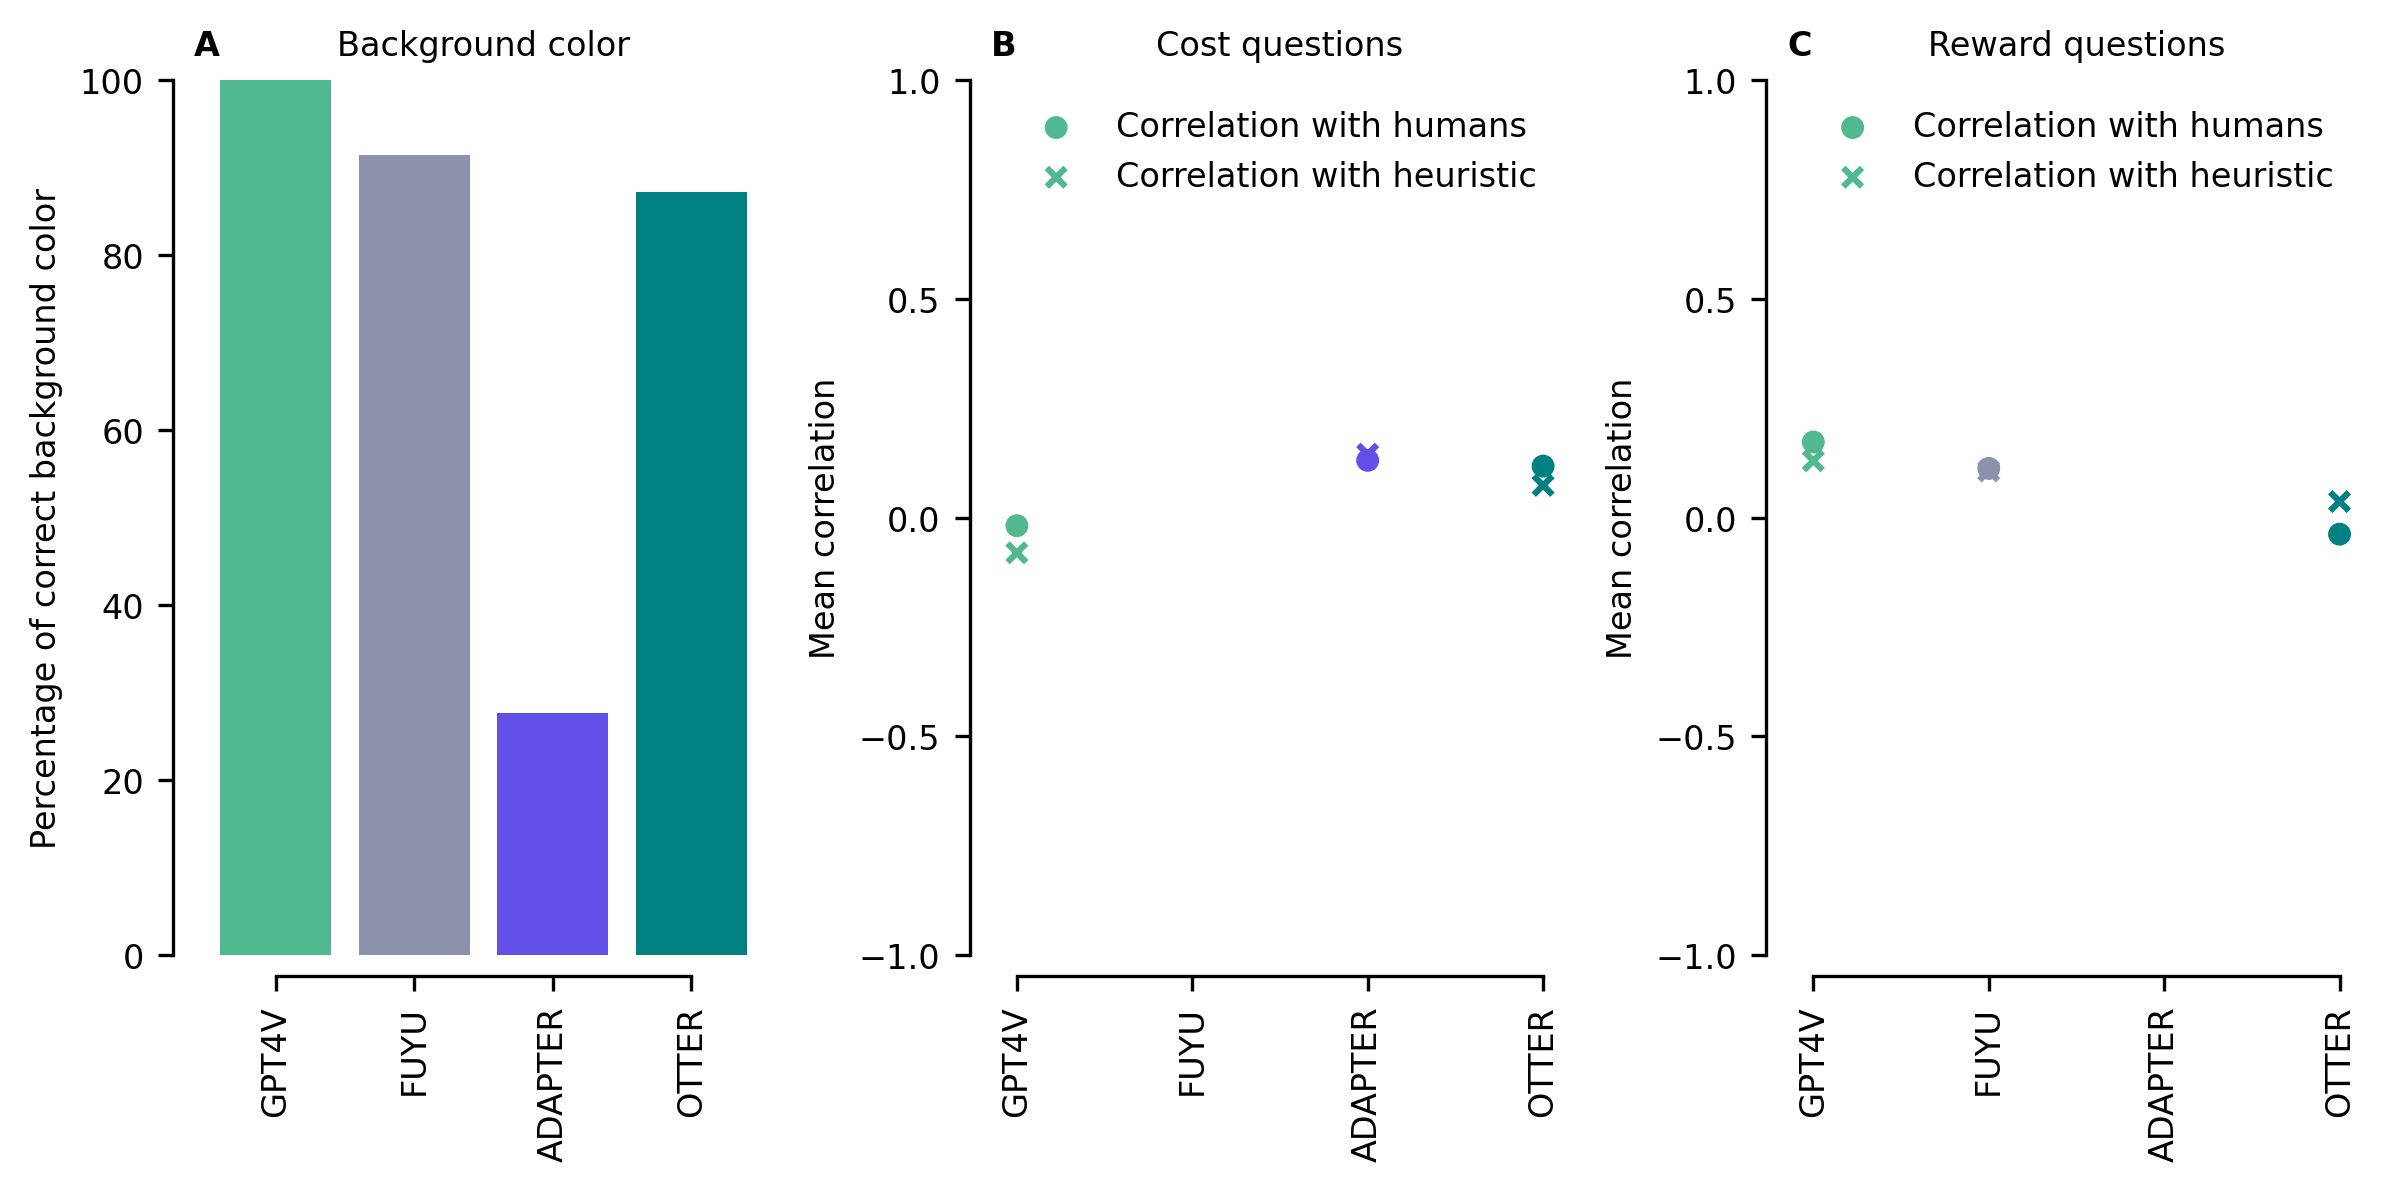

In [18]:
# Prepare plot
num_subjects = len(subjects)
fig, axs = plt.subplots(1, 3, figsize=(8,4), sharey=False, tight_layout=True)  

# Plot A
axs[0].bar(np.arange(num_subjects-1), color_correct*100, color=model_colors)
axs[0].set_title("Background color")
axs[0].set_title("A", fontweight='bold', loc='left')
axs[0].set_ylabel("Percentage of correct background color")
axs[0].set_ylim(0, 100)
axs[0].set_xticks(np.arange(num_subjects-1))

# Plot B
axs[1].scatter(np.arange(num_subjects-1), cocorr_all, s=20, color=model_colors[:-1], marker="o", label="Correlation with humans")
axs[1].scatter(np.arange(num_subjects-1), heucocorr_all, s=20, color=model_colors[:-1], marker="x", label="Correlation with heuristic")
axs[1].set_title("Cost questions")
axs[1].set_title("B", fontweight='bold', loc='left')
axs[1].set_ylabel("Mean correlation")
axs[1].set_ylim(-1, 1)
axs[1].set_yticks(np.arange(-1, 1.1, 0.5))
axs[1].set_xticks(np.arange(num_subjects-1))
axs[1].legend(loc="upper center", frameon=False)

# Plot C
axs[2].scatter(np.arange(num_subjects-1), recorr_all, s=20, color=model_colors[:-1], marker="o", label="Correlation with humans")
axs[2].scatter(np.arange(num_subjects-1), heurecorr_all, s=20, color=model_colors[:-1], marker="x", label="Correlation with heuristic")
axs[2].set_title("Reward questions")
axs[2].set_title("C", fontweight='bold', loc='left')
axs[2].set_ylabel("Mean correlation")
axs[2].set_ylim(-1, 1)
axs[2].set_yticks(np.arange(-1, 1.1, 0.5))
axs[2].set_xticks(np.arange(num_subjects-1))
axs[2].legend(loc="upper center", frameon=False)

# Despine and set x tick labels afterwards
sns.despine(offset=5, trim=True)
axs[0].set_xticklabels(np.concatenate((["GPT4V"], subjects[2:])), rotation=90)
axs[1].set_xticklabels(np.concatenate((["GPT4V"], subjects[2:])), rotation=90)
axs[2].set_xticklabels(np.concatenate((["GPT4V"], subjects[2:])), rotation=90)
plt.savefig("exp1_main.pdf", dpi=300)

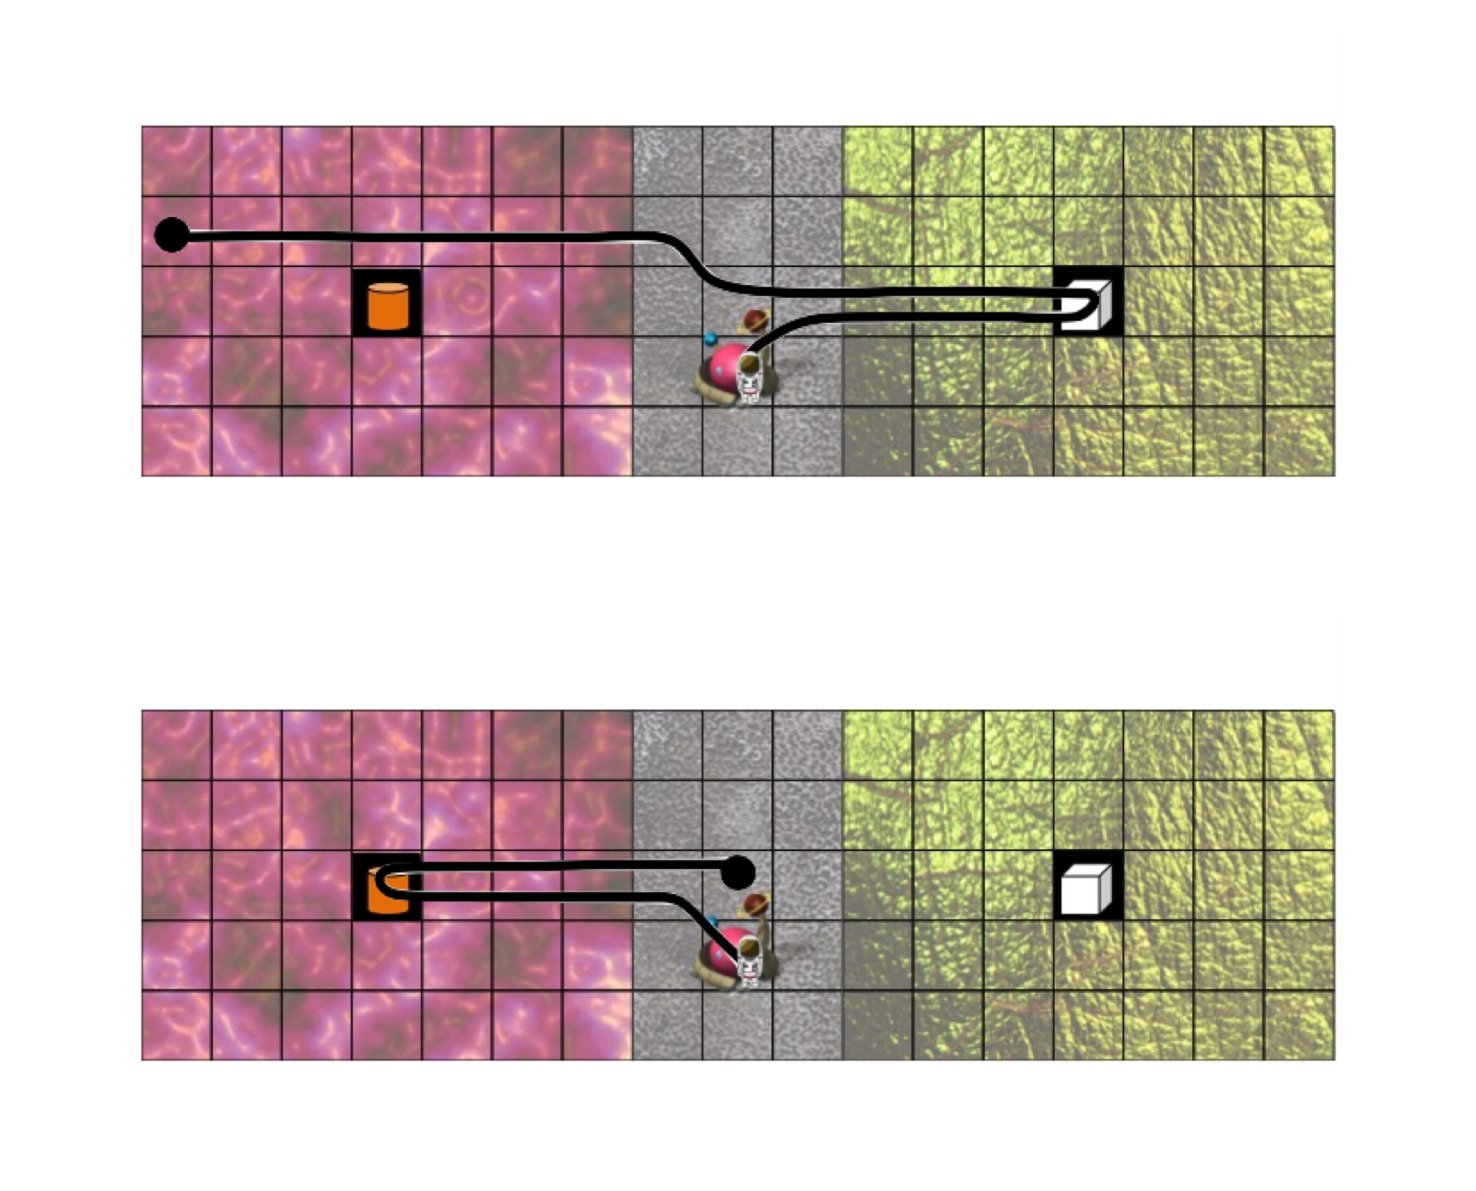

In [ ]:
# Prepare plot
fig, axs = plt.subplots(2, 1, sharey=False, tight_layout=True, figsize=(6,4))  

# First column: easy for humans, hard for GPT4V (20, 11)
axs[0].imshow(plt.imread("images/naive_util_calc_images/Exp1b/3.png"))
axs[0].axis("off")

axs[1].imshow(plt.imread("images/naive_util_calc_images/Exp1b/1.png"))
axs[1].axis("off")

plt.savefig("exp1_examples.pdf", dpi=300, bbox_inches='tight')